In [1]:
import pandas as pd
import numpy as np
import math
import time
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

import constant
import tools
import myplot
import features
from models import MLP, LSTM_Regression, train_model, timeseries_kfold_validation_training, Evaluation

# 1. Load Files

In [2]:
settlement = pd.read_parquet(constant.settlement_2019_path)
# settlement = pd.read_parquet(constant.settlement_2018_path).append(pd.read_parquet(constant.settlement_2019_path))
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmill = pd.read_csv(constant.windmill_path, dtype=dtype)

wu10 = pd.read_parquet(constant.wu10_path)
wv10 = pd.read_parquet(constant.wv10_path)
wu100 = pd.read_parquet(constant.wu100_path)
wv100 = pd.read_parquet(constant.wv100_path)

ws10 = pd.read_parquet(constant.ws10_path)
ws100 = pd.read_parquet(constant.ws100_path)

tmp2 = pd.read_parquet(constant.tmp2_path)
tmp100 = pd.read_parquet(constant.tmp100_path)

In [3]:
windmill = windmill[windmill["GSRN"] == "570714700000004070"]

### Aggregate windmill and settlement

In [4]:
df = pd.merge(windmill, settlement, on="GSRN")

# 2. Feature Extraction

In [5]:
features.fun_register(wu10, wv10, wu100, wv100, tmp2, tmp100)
df = features.parallelize_extract(df)

41.064757108688354


In [6]:
cols_filter = ["grid", "month", "hour", "GSRN", "Turbine_type", "Placement", "Rotor_diameter", "Navhub_height", "Elevation", "Roughness", "Parent_GSRN", "BBR_municipal", 'Capacity_kw', 'Slope', 'Aspect']

In [7]:
cols = [x for x in df.columns if x not in cols_filter + ["TIME_CET","predicted_ahead"]]
df[cols] = tools.normalize_maxmin(df[cols]).fillna(0)

In [8]:
df["TIME_CET"] = pd.to_datetime(df["TIME_CET"])
date_s = pd.to_datetime("2019-12-05")
date_e = pd.to_datetime("2019-12-06")
df_train = df[df["TIME_CET"] < date_s].sort_values(["GSRN", "TIME_CET"]).reset_index(drop=True)
df_evl = df[df["TIME_CET"] >= date_s][df["TIME_CET"] < date_e].sort_values(["GSRN", "TIME_CET"]).reset_index(drop=True)

# Prediction NN - Geo Free

In [9]:
cols = ['hws_u_wsr','hws_v_wsr','hws_uv_wsr','hws_uv_wsr^2','hws_uv_wsr^3','htmp_exp',
'hws_uv_wsr_q0.1','hws_uv_wsr_q0.3','hws_uv_wsr_q0.5','hws_uv_wsr_q0.7','hws_uv_wsr_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [10]:
model_geofree = MLP(
  input_size=47,
  hidden_size=1000,
  output_size=1
)
model_geofree, train_hist_geofree, test_hist_geofree = timeseries_kfold_validation_training(df=df_train, features=cols, target=["VAERDI"], n_groups=5, model=model_geofree, lr=0.001, num_epochs=30)

Epoch 0 train loss: 0.07952086627483368 test loss: 0.0565498024225235
Epoch 10 train loss: 0.009067649021744728 test loss: 0.020871330052614212
Epoch 19 train loss: 0.006841709371656179 test loss: 0.02856965735554695
Epoch 0 train loss: 0.01799813285470009 test loss: 0.022377068176865578
Epoch 10 train loss: 0.008948377333581448 test loss: 0.01047494262456894
Epoch 19 train loss: 0.007338940165936947 test loss: 0.00736469030380249
Epoch 0 train loss: 0.007113102823495865 test loss: 0.012382950633764267
Epoch 10 train loss: 0.006026831455528736 test loss: 0.010903064161539078
Epoch 19 train loss: 0.0049887546338140965 test loss: 0.008347589522600174
Epoch 0 train loss: 0.005631993990391493 test loss: 0.014596733264625072
Epoch 10 train loss: 0.00480847479775548 test loss: 0.012577731162309647
Epoch 19 train loss: 0.004279134329408407 test loss: 0.010248465463519096


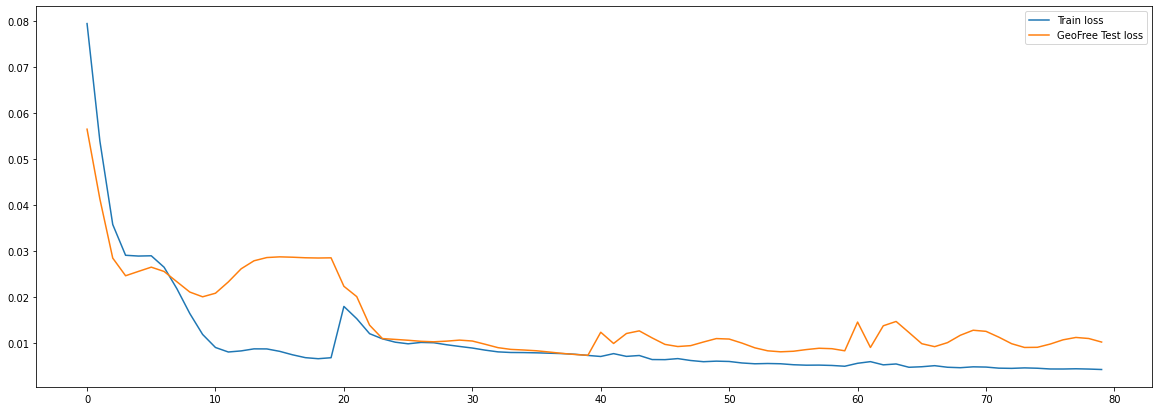

In [11]:
myplot.Model_Loss({"Train loss":train_hist_geofree, "GeoFree Test loss": test_hist_geofree})

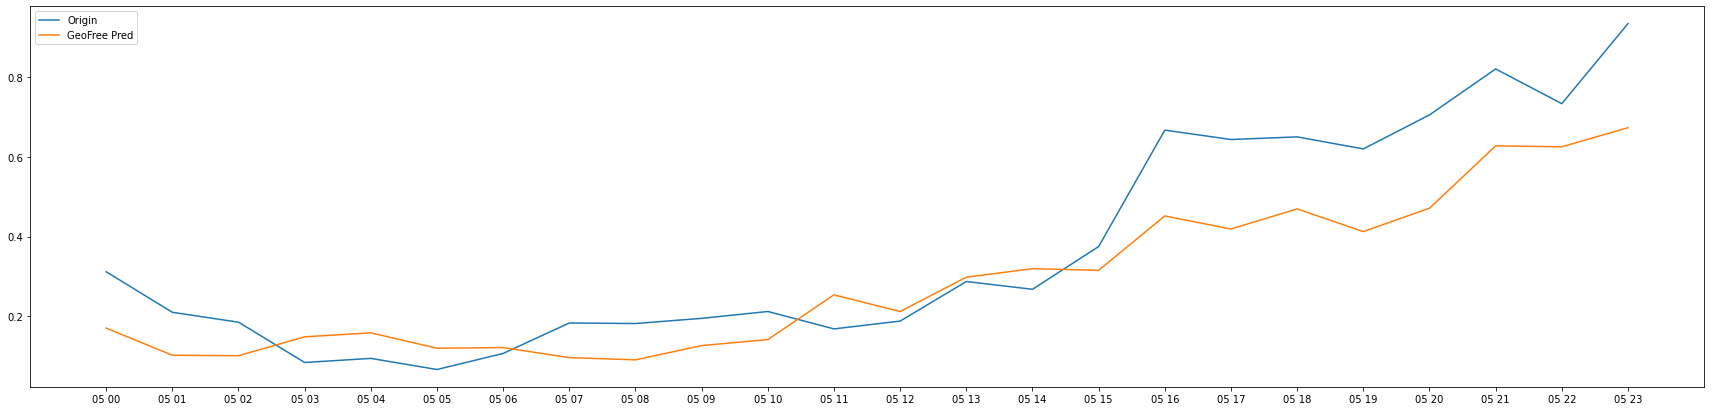

In [12]:
x_test_tensor = torch.tensor(df_evl[cols].values, dtype = torch.float)
y_pred_tensor = model_geofree(x_test_tensor)
df_evl["pred"] = y_pred_tensor.detach().flatten().numpy()
myplot.timelines_plot(df_evl["TIME_CET"], {"Origin": df_evl["VAERDI"], "GeoFree Pred":df_evl["pred"]})

### Evaluation by test
BIAS, MAE, MSE, RMSE

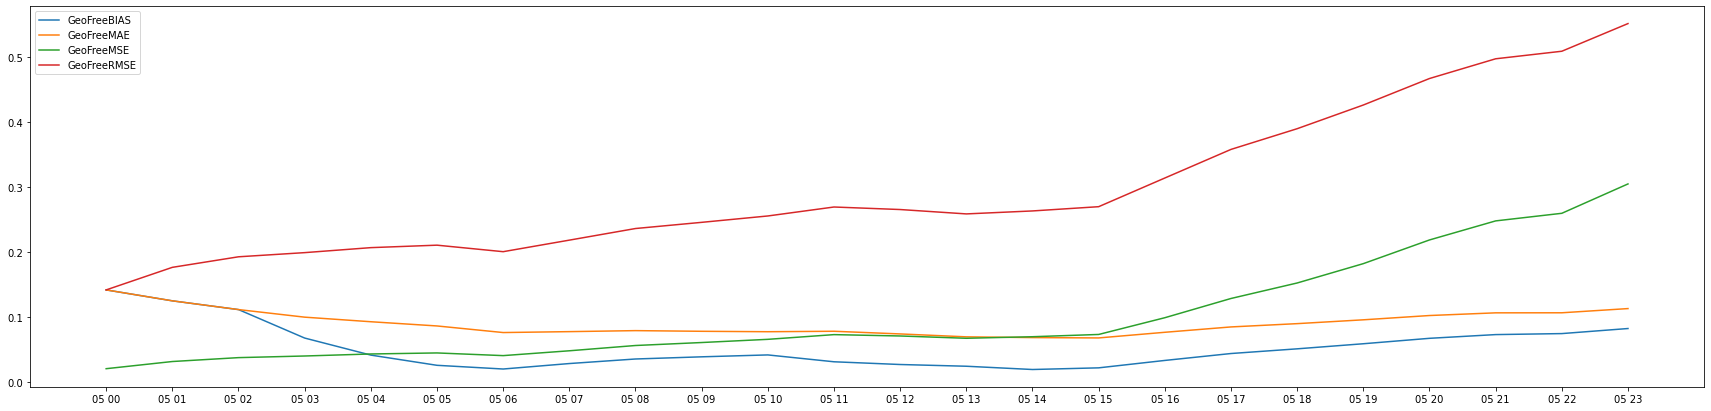

BIAS:  0.08197147675832635
MAE:  0.11272504882660243
MSE:  0.30496647919103764
RMSE:  0.5522377017109912
R^2 Score:  0.739932055461769


In [13]:
errors = Evaluation(df_evl[["TIME_CET", "VAERDI", "pred"]], "GeoFree")
print("BIAS: ", errors["GeoFree_BIAS"].iloc[-1])
print("MAE: ", errors["GeoFree_MAE"].iloc[-1])
print("MSE: ", errors["GeoFree_MSE"].iloc[-1])
print("RMSE: ", errors["GeoFree_RMSE"].iloc[-1])
print("R^2 Score: ", errors["GeoFree_R^2"].iloc[-1])

# Prediction NN - Geo

In [14]:
cols = ['hws_u_rn','hws_v_rn','hws_uv_rn','hws_uv_rn^2','hws_uv_rn^3','htmp_exp',
'hws_uv_rn_q0.1','hws_uv_rn_q0.3','hws_uv_rn_q0.5','hws_uv_rn_q0.7','hws_uv_rn_q0.9',
'm1', 'm2', 'm3', 'm4', 'm5', 'm6', 'm7', 'm8', 'm9', 'm10', 'm11', 'm12',
'h0', 'h1', 'h2', 'h3', 'h4', 'h5', 'h6', 'h7', 'h8', 'h9', 'h10', 'h11', 'h12', 'h13', 'h14', 'h15', 'h16', 'h17', 'h18', 'h19', 'h20', 'h21', 'h22', 'h23']

In [15]:
model_geo = MLP(
  input_size=47,
  hidden_size=1000,
  output_size=1
)
model_geo, train_hist_geo, test_hist_geo = timeseries_kfold_validation_training(df=df_train, features=cols, target=["VAERDI"], n_groups=6, model=model_geo, lr=0.001, num_epochs=30)

Epoch 0 train loss: 0.059152811765670776 test loss: 0.05469062551856041
Epoch 10 train loss: 0.008317084982991219 test loss: 0.013159778900444508
Epoch 20 train loss: 0.007710219826549292 test loss: 0.017226984724402428
Epoch 29 train loss: 0.006346325855702162 test loss: 0.01631564274430275
Epoch 0 train loss: 0.011134989559650421 test loss: 0.03206586837768555
Epoch 10 train loss: 0.007267709355801344 test loss: 0.02176075428724289
Epoch 20 train loss: 0.006011387798935175 test loss: 0.01930970884859562
Epoch 29 train loss: 0.005377666559070349 test loss: 0.016405576840043068
Epoch 0 train loss: 0.009107034653425217 test loss: 0.0097430981695652
Epoch 10 train loss: 0.006162319332361221 test loss: 0.007577996235340834
Epoch 20 train loss: 0.005246004555374384 test loss: 0.006256511434912682
Epoch 29 train loss: 0.004679713398218155 test loss: 0.005567511077970266
Epoch 0 train loss: 0.004886613693088293 test loss: 0.006091193296015263
Epoch 10 train loss: 0.004392537288367748 test lo

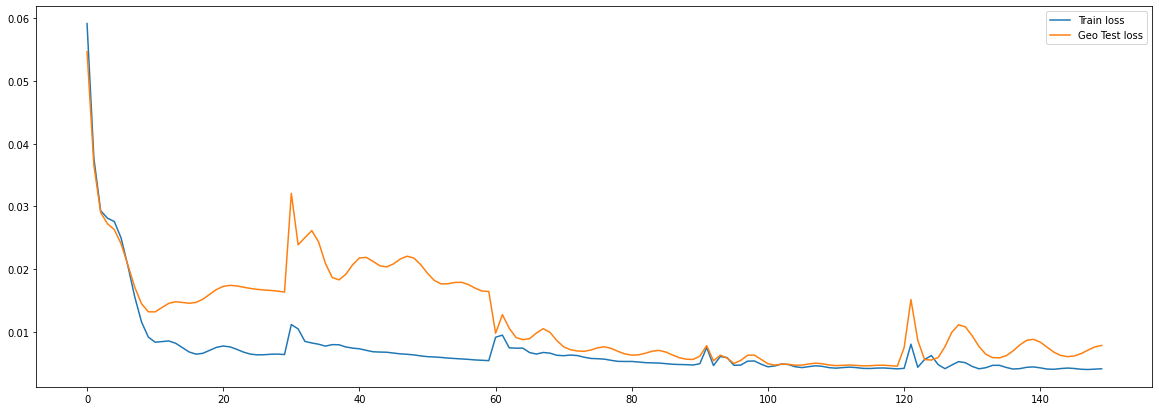

In [16]:
myplot.Model_Loss({"Train loss":train_hist_geo, "Geo Test loss": test_hist_geo})

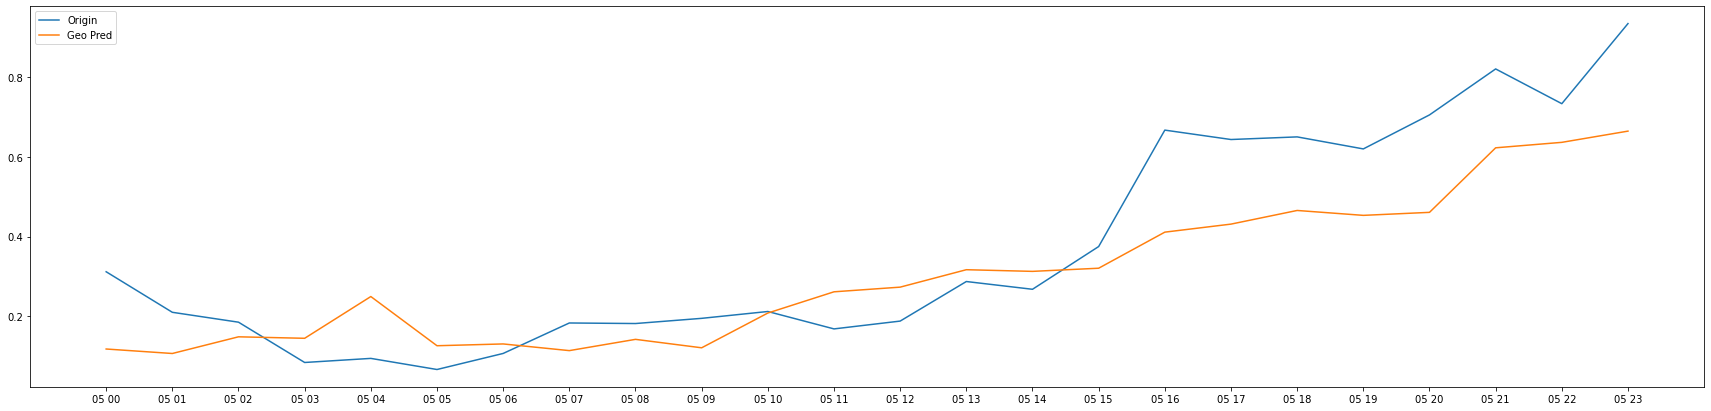

In [17]:
x_test_tensor = torch.tensor(df_evl[cols].values, dtype = torch.float)
y_pred_tensor = model_geo(x_test_tensor)
df_evl["pred"] = y_pred_tensor.detach().flatten().numpy()
myplot.timelines_plot(df_evl["TIME_CET"], {"Origin": df_evl["VAERDI"], "Geo Pred":df_evl["pred"]})

### Evaluation

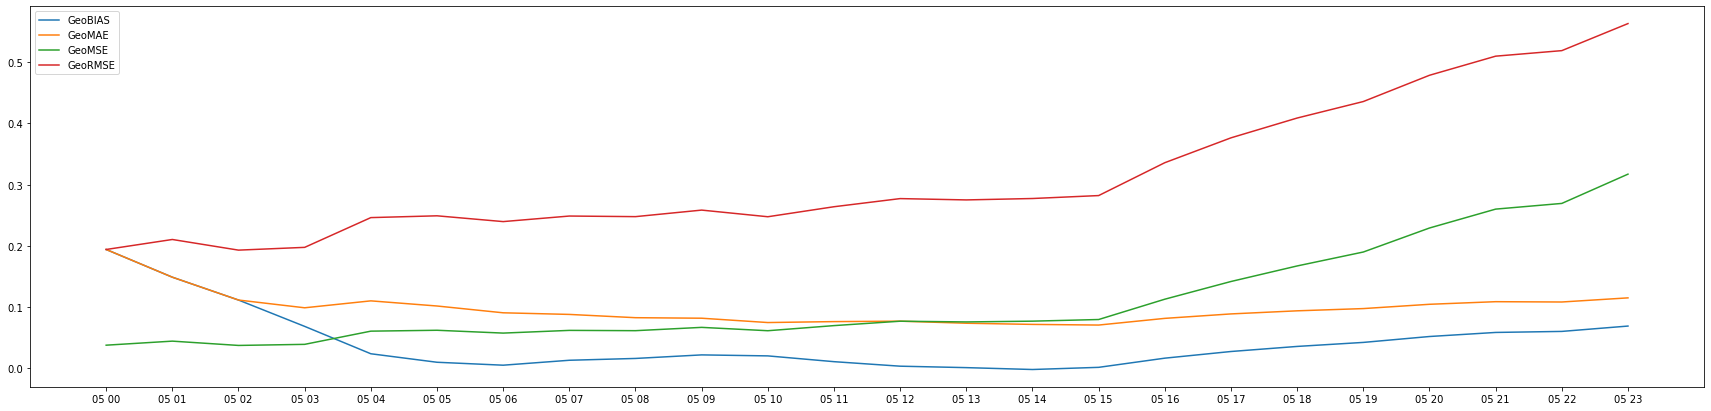

BIAS:  0.0688848138201289
MAE:  0.11494445509360962
MSE:  0.31709346616240414
RMSE:  0.5631105274831968
R^2 Score:  0.719229392329179


In [18]:
errors = Evaluation(df_evl[["TIME_CET", "VAERDI", "pred"]], "Geo")
print("BIAS: ", errors["Geo_BIAS"].iloc[-1])
print("MAE: ", errors["Geo_MAE"].iloc[-1])
print("MSE: ", errors["Geo_MSE"].iloc[-1])
print("RMSE: ", errors["Geo_RMSE"].iloc[-1])
print("R^2 Score: ", errors["Geo_R^2"].iloc[-1])